# Notebook 3 - Running BiG-SCAPE and Calculating Beta-Diversity

This notebook helps to run BiG-SCAPE for the annotated genomes and how to calculate beta-diversity for highlighting the most promising cyaniobacterial genomes


In [2]:
import pandas as pd
import glob
import os
import subprocess
import re
# from Bio import SeqIO
import numpy as np
import networkx
from networkx.algorithms.components.connected import connected_components
from collections import defaultdict
import seaborn as sns

**Downloading MIBiG BGCs**

```bash
cd ./ncbi_antismash/nf_output/
wget https://dl.secondarymetabolites.org/mibig/mibig_gbk_2.0.tar.gz
tar xvzf mibig_gbk_2.0.tar.gz
rm mibig_gbk_2.0.tar.gz
```

**Running BiG-SCAPE**

```bash
python /home/jovyan/jupyterdata/tiago/dorrestein_nuno/bigscape/BiG-SCAPE/bigscape.py \
-i /home/jovyan/jupyterdata/tiago/cyanobiome/ncbi_antismash/nf_output/ \
-o /home/jovyan/jupyterdata/tiago/cyanobiome/bigscape_outputs/ \
-c 12 --include_singletons --pfam_dir /home/jovyan/jupyterdata/tiago/dorrestein_nuno/bigscape/
```

**Gathering BiG-SCAPE Results**

In [162]:
%%bash

cd ./bigscape_outputs/

rm ./bigscape_all_c030.txt
find ./network_files/2020-05-16_22-19-49_hybrids_glocal/ -type f -name *_c0.30.network | cat > ./network_files.txt
while read line; do cat $line >> ./pre_bigscape_all_c030.txt; done < ./network_files.txt
awk '/Clustername/&&c++>0 {next} 1' ./pre_bigscape_all_c030.txt >> ./bigscape_all_c030.txt

In [3]:
def get_bigscape_df(input_file):
    bigscape_df = pd.read_csv(input_file,sep='\t')
    bigscape_df.rename(columns=lambda x: re.sub(' ','_',x), inplace=True)
    bigscape_df = bigscape_df[bigscape_df.Clustername_1 != bigscape_df.Clustername_2]
    bigscape_df.reset_index(inplace=True,drop=True)
    return bigscape_df

bigscape_df = get_bigscape_df("./bigscape_outputs/bigscape_all_c030.txt")

bigscape_df[:5]

,Clustername_1,Clustername_2,Raw_distance,Squared_similarity,Jaccard_index,DSS_index,Adjacency_index,raw_DSS_non-anchor,raw_DSS_anchor,Non-anchor_domains,Anchor_domains,Combined_group,Shared_group
0,PXPV01000027.1.region001,PXPY01000236.1.region001,0.115125,0.783004,1.000000,0.884260,0.857143,0.115740,0.0,12,0,siderophore - siderophore,siderophore
1,AJLL01000049.1.region001,NGZT01000062.1.region001,0.033442,0.934235,0.928571,0.969697,0.833333,0.058824,0.0,17,4,hglE-KS.resorcinol - hglE-KS.resorcinol,hglE-KS.resorcinol
2,PXPM01000050.1.region001,PXQG01000022.1.region001,0.148245,0.725487,0.777778,0.860708,0.454545,0.139292,0.0,10,0,siderophore - siderophore,siderophore
3,QOPQ01000007.1.region001,c00035_gi1022...region001,0.267240,0.536937,0.947368,0.728130,0.850000,0.271870,0.0,24,0,terpene.bacteriocin - terpene.bacteriocin,terpene.bacteriocin
4,NHDT02000030.1.region001,SHBU01000008.1.region001,0.279188,0.519570,0.875000,0.716412,0.857143,0.283588,0.0,7,0,terpene.bacteriocin - terpene.bacteriocin,terpene.bacteriocin


**Replacing Distance by Similarity**

In [4]:
sim_col = []

for i,r in bigscape_df.iterrows():
    similarity = 1 - float(bigscape_df['Raw_distance'].loc[i])
    sim_col.append(similarity)

bigscape_df['Raw_distance'] = sim_col
bigscape_df.rename(columns={'Raw_distance':'Similarity'}, inplace=True)

bigscape_df[:5]

,Clustername_1,Clustername_2,Similarity,Squared_similarity,Jaccard_index,DSS_index,Adjacency_index,raw_DSS_non-anchor,raw_DSS_anchor,Non-anchor_domains,Anchor_domains,Combined_group,Shared_group
0,PXPV01000027.1.region001,PXPY01000236.1.region001,0.884875,0.783004,1.000000,0.884260,0.857143,0.115740,0.0,12,0,siderophore - siderophore,siderophore
1,AJLL01000049.1.region001,NGZT01000062.1.region001,0.966558,0.934235,0.928571,0.969697,0.833333,0.058824,0.0,17,4,hglE-KS.resorcinol - hglE-KS.resorcinol,hglE-KS.resorcinol
2,PXPM01000050.1.region001,PXQG01000022.1.region001,0.851755,0.725487,0.777778,0.860708,0.454545,0.139292,0.0,10,0,siderophore - siderophore,siderophore
3,QOPQ01000007.1.region001,c00035_gi1022...region001,0.732760,0.536937,0.947368,0.728130,0.850000,0.271870,0.0,24,0,terpene.bacteriocin - terpene.bacteriocin,terpene.bacteriocin
4,NHDT02000030.1.region001,SHBU01000008.1.region001,0.720812,0.519570,0.875000,0.716412,0.857143,0.283588,0.0,7,0,terpene.bacteriocin - terpene.bacteriocin,terpene.bacteriocin


**Replacing Names for More Useful Labels**

In [5]:
def parse_gbk_list(folder_list):
    gbk_list,new_name_list = [],[]
    for antismash_folder in folder_list:
        print("Parsing BGCs from folder %s"%antismash_folder)
        for root, dirs, files in os.walk(antismash_folder):
            count = 1
            for file in sorted(files):
                if file.endswith(".gbk"):
                    if 'region' in file:
                        if 'BGC' in file:
                            new_name = file.rstrip('.gbk')
                            new_name_list.append(new_name)
                            gbk_list.append(file.rstrip('.gbk'))
                        else:
                            strain_name = os.path.basename(os.path.normpath(root)).split('.')[0]
                            gbk_list.append(file.rstrip('.gbk'))
                            new_name = strain_name + '.region' + "{0:0=3d}".format(count)
                            count += 1
                            new_name_list.append(new_name)
    return gbk_list,new_name_list

folder_list = ["/Users/tiagoferreiraleao/Dropbox/tiago-NAS/cyanobiome/ncbi_antismash/nf_output/"]

gbk_list,new_name_list = parse_gbk_list(folder_list)

Parsing BGCs from folder /Users/tiagoferreiraleao/Dropbox/tiago-NAS/cyanobiome/ncbi_antismash/nf_output/


In [6]:
len(gbk_list),len(new_name_list)

(14380, 14380)

In [7]:
name_dict = dict(zip(gbk_list, new_name_list))
new_col1, new_col2 = [],[]

for i,r in bigscape_df.iterrows():
    new_col1.append(name_dict[bigscape_df['Clustername_1'].loc[i]])
    new_col2.append(name_dict[bigscape_df['Clustername_2'].loc[i]])
    
bigscape_df['Clustername_1'] = new_col1
bigscape_df['Clustername_2'] = new_col2

bigscape_df[:5]

,Clustername_1,Clustername_2,Similarity,Squared_similarity,Jaccard_index,DSS_index,Adjacency_index,raw_DSS_non-anchor,raw_DSS_anchor,Non-anchor_domains,Anchor_domains,Combined_group,Shared_group
0,PXPV01.region001,PXPY01.region007,0.884875,0.783004,1.000000,0.884260,0.857143,0.115740,0.0,12,0,siderophore - siderophore,siderophore
1,AJLL01.region005,NGZT01.region008,0.966558,0.934235,0.928571,0.969697,0.833333,0.058824,0.0,17,4,hglE-KS.resorcinol - hglE-KS.resorcinol,hglE-KS.resorcinol
2,PXPM01.region001,PXQG01.region001,0.851755,0.725487,0.777778,0.860708,0.454545,0.139292,0.0,10,0,siderophore - siderophore,siderophore
3,QOPQ01.region002,LVHK01.region009,0.732760,0.536937,0.947368,0.728130,0.850000,0.271870,0.0,24,0,terpene.bacteriocin - terpene.bacteriocin,terpene.bacteriocin
4,NHDT02.region001,SHBU01.region004,0.720812,0.519570,0.875000,0.716412,0.857143,0.283588,0.0,7,0,terpene.bacteriocin - terpene.bacteriocin,terpene.bacteriocin


**Obtaining Gene Cluster Families**

In [8]:
def get_neighbors(target,dataframe,column1,column2):
    subset1 = dataframe[(dataframe[column1]==target)]
    subcat = subset1.append(dataframe[(dataframe[column2]==target)])
    temp_list = []
    for index,row in subcat.iterrows():
        temp_list.append(subcat[column1][index])
        temp_list.append(subcat[column2][index])
    temp_list = list(np.unique(temp_list))
    return temp_list

def to_edges(l):
    '''This function convert a list of group of nodes into edges
    Script adapted from https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements/4842783
    '''
    it = iter(l)
    last = next(it)
    for current in it:
        yield last, current
        last = current

def to_graph(l):
    '''This function generate a graph using a list of group of nodes and the edges create with the function to_edges()
    Script adapted from https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements/4842783
    '''
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def get_family_dict(components_list,dataframe,dictionary):
    count = 0
    for family in list(components_list):
        count += 1
        for fam_member in family:
            dictionary['GCF%s'%count].append(fam_member)
    return dictionary

def main_get_families(input_file,bigscape_df):
    targets_list = np.unique([bigscape_df.Clustername_1,bigscape_df.Clustername_2])
    neighbors_list = []
    for target in targets_list:
        neighbors_list.append(get_neighbors(target,bigscape_df,'Clustername_1','Clustername_2'))
    G = to_graph(neighbors_list)
    C = connected_components(G)
    gcf_dict = defaultdict(list)
    gcf_dict = get_family_dict(C,bigscape_df,gcf_dict)
    return gcf_dict

In [9]:
gcf_dict = main_get_families('./bigscape_outputs/bigscape_all_c030.txt',bigscape_df)

In [10]:
gcf_dict

defaultdict(list,
            {'GCF1': ['.region001',
              'AESD01.region003',
              'CAQK01.region015',
              'CAQL01.region002',
              'CAQM01.region009',
              'AADV02.region001'],
             'GCF2': ['AESD01.region013',
              'CAQL01.region020',
              'AESD01.region004',
              'AADV02.region002',
              'CAQK01.region019',
              'CAQL01.region011',
              'AGJC02.region007',
              'CAQM01.region002',
              'CAQN01.region009',
              'CAQN01.region019',
              'CAQM01.region001'],
             'GCF3': ['CAQM01.region006', 'AADV02.region007'],
             'GCF4': ['PRLH01.region005',
              'AADV02.region008',
              'CAQK01.region008',
              'AGJC02.region006',
              'AAXW01.region005',
              'AESD01.region012',
              'CAQL01.region009',
              'CAQM01.region003',
              'CAQN01.region014',
              '

**Obtaining GCF Distribution in the Analized Genomes**

In [11]:
cluster_list = []
strains = []

for item in gcf_dict.values():
    cluster_list = cluster_list + item

for item in cluster_list:
    if 'BGC' in item[:3]:
        strains.append('MIBiG')
    else:
        strains.append(item.split('.')[0])

col_names = list(np.unique(strains))

col_names.remove('')

col_names

['AADV02',
 'AANO01',
 'AANP01',
 'AAOK01',
 'AATZ01',
 'AAUA01',
 'AAVU01',
 'AAVW01',
 'AAXW01',
 'ABRS01',
 'ABRV01',
 'ABSE01',
 'ABYK01',
 'ACDW01',
 'ACSK03',
 'ACYA01',
 'ACYB01',
 'ADXM01',
 'AEPQ01',
 'AESD01',
 'AFJC01',
 'AFXD01',
 'AGCR01',
 'AGIK01',
 'AGIZ01',
 'AGJC02',
 'AJHB01',
 'AJLJ01',
 'AJLK01',
 'AJLL01',
 'AJLM01',
 'AJLN01',
 'AJTX02',
 'AJUS01',
 'AJUT01',
 'AJUU01',
 'AJWF01',
 'AJYB01',
 'ALPD01',
 'ALPE01',
 'ALPF01',
 'ALPH01',
 'ALPJ01',
 'ALPK01',
 'ALVI01',
 'ALVJ01',
 'ALVM01',
 'ALVN01',
 'ALVP01',
 'ALVS01',
 'ALVT01',
 'ALVU02',
 'ALVW01',
 'ALVX01',
 'ALVY01',
 'ALWA01',
 'ALWB01',
 'ALWD01',
 'ANFJ01',
 'ANFQ01',
 'ANKN01',
 'ANKQ01',
 'ANNX02',
 'AOCI01',
 'APIY01',
 'APIZ01',
 'AQPY01',
 'ASAK01',
 'ASZQ01',
 'AUMZ01',
 'AUNA01',
 'AUZM01',
 'AVFS01',
 'AVFT01',
 'AVFU01',
 'AVFV01',
 'AVFW01',
 'AVFX01',
 'AVFY01',
 'AVFZ01',
 'AWNH01',
 'AXAQ01',
 'AXUV01',
 'AXUW01',
 'AXUX01',
 'AXZO01',
 'AZXL01',
 'AZYY01',
 'BAUB01',
 'BAWS01',
 'BBPA01',

In [12]:
family_rows = []
indexes = []

for key,value in gcf_dict.items():
    indexes.append(key)
    row = []
    for strain in col_names:
        if strain == "MIBiG":
            find_substring_in_list = [s for s in value if "BGC" in s]
            sublist = filter(lambda x: "BGC" in x, value)
            sublist = list(sublist)
        else:
            find_substring_in_list = [s for s in value if strain.lower() in s.lower()] # .lower() for case insensitive
            sublist = filter(lambda x: strain in x, value)
            sublist = list(sublist)
            for item in find_substring_in_list:
                if 'BGC' in item[:3]:
                    find_substring_in_list.remove(item)
                    sublist.remove(item)
        if find_substring_in_list:
            row.append(sublist)
        else:
            row.append(0)
    family_rows.append(row)
    
gcf_patterns = pd.DataFrame(family_rows,columns=col_names,index=indexes)

In [13]:
gcf_patterns

,AADV02,AANO01,AANP01,AAOK01,AATZ01,AAUA01,AAVU01,AAVW01,AAXW01,ABRS01,...,UCNJ01,UCNL01,UCNM01,UCNN01,UCNR01,UCNU01,UCNV01,UCNW01,UCNZ01,UCOB01
GCF1,[AADV02.region001],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF2,[AADV02.region002],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF3,[AADV02.region007],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF4,[AADV02.region008],0,0,0,0,0,0,0,[AAXW01.region005],0,...,0,0,0,0,0,0,0,0,0,0
GCF5,[AADV02.region010],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF1080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF1081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF1082,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF1083,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
gcf_patterns.to_csv("./outputs/gcf_patterns-TFL201112.tsv",sep='\t')

**Converting GCF Distribution into Binary for Plotting Heatmap**

In [18]:
family_counts = []

for i,r in gcf_patterns.iterrows():
    new_row = []
    for item in r:
        if item == 0:
            new_row.append(0)
        else:
            new_row.append(1)
    family_counts.append(new_row)
    
gcf_binary = pd.DataFrame(family_counts,columns=col_names,index=indexes)

gcf_binary[:5]

,AADV02,AANO01,AANP01,AAOK01,AATZ01,AAUA01,AAVU01,AAVW01,AAXW01,ABRS01,...,UCNJ01,UCNL01,UCNM01,UCNN01,UCNR01,UCNU01,UCNV01,UCNW01,UCNZ01,UCOB01
GCF1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCF4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
GCF5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Calculating Beta-Diversity and Creating Figure 2b**

In [21]:
from scipy.spatial import distance
from scipy.cluster import hierarchy
import seaborn as sns
from skbio.diversity import beta_diversity
import matplotlib.pyplot as plt
sns.set()
#sns.set_context("talk")
%matplotlib inline

header = list(gcf_binary.columns.values)
# gcf_binary.index.names = ['GCFs']

ids = gcf_binary.columns.astype(str).tolist()
# data = gcf_binary.as_matrix()
data = gcf_binary[col_names].values
data = data.transpose()
data = data.astype(int)

bc_dm = beta_diversity('jaccard', data, ids)
bc_dm_df = bc_dm.to_data_frame()

/Users/tiagoferreiraleao/anaconda3/envs/gnps/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1765: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Jaccard Similarity (0.0-1.0):


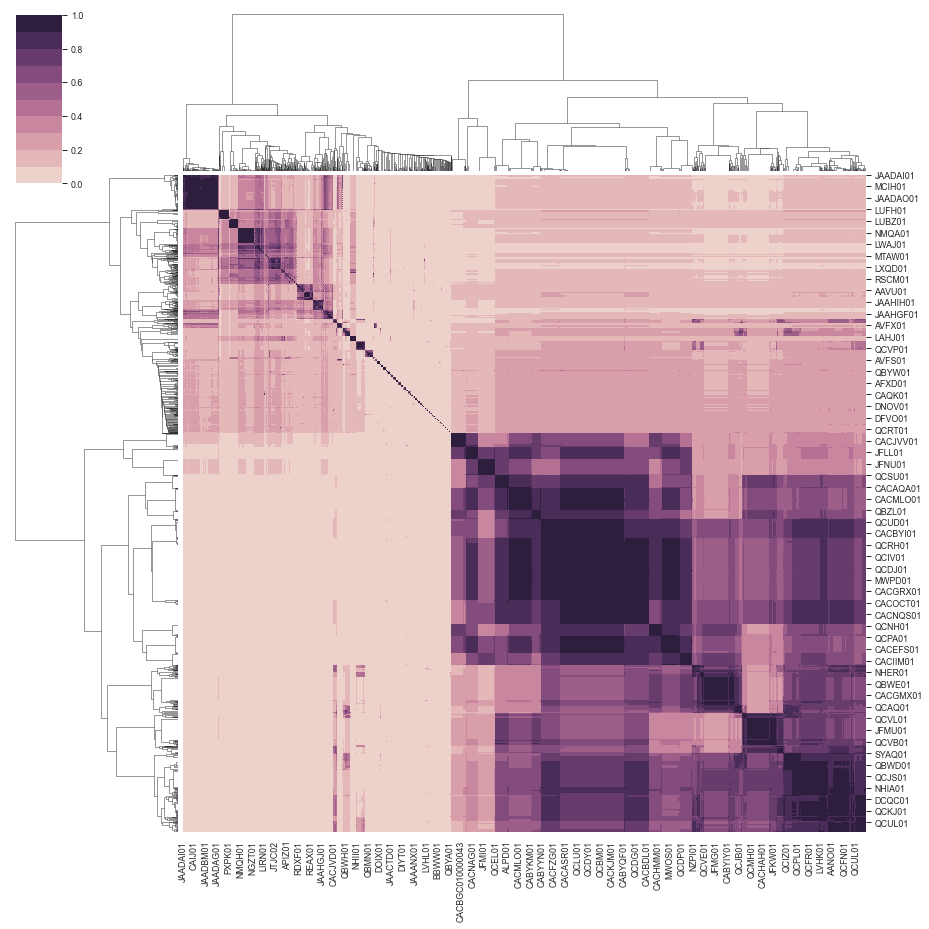

In [22]:
sns.set_context("paper")

correlations = bc_dm_df.corr()
correlations_array = np.asarray(bc_dm_df.corr())

row_linkage = hierarchy.linkage(distance.pdist(correlations_array), method='average')

col_linkage = hierarchy.linkage(distance.pdist(correlations_array.T), method='average')

palette = sns.cubehelix_palette(10)

sns.clustermap(correlations, row_linkage=row_linkage, col_linkage=col_linkage,
               figsize=(13, 13),standard_scale=1,cmap=palette)

print("Jaccard Similarity (0.0-1.0):")

# plt.savefig("./big-scape/outputs/beta-diversity_%s.png"%(int(cutoff*10)),format="png")

In [24]:
cyanobiome_list = ['JAAHII01','JAAHIH01','JAAHGF01','JAAHHC01','JAAHHD01','JAAHFN01','JAAHGM01','JAAHGB01','JAAHFW01','JAAHFZ01','JAAHFP01','JAAHGH01','JAAHGC01','JAAHGA01','JAAHHJ01','JAAHGO01','JAAHGU01','JAAHGW01','JAAHGS01','JAAHHM01','JAAHHP01','JAAHHN01','JAAHGL01','JAAHFU01']

In [53]:
most_promising_color = {}

for key,value in diversity_scores.items():
    if key in cyanobiome_list:
        most_promising_color[key] = {"diversity":"cyanobiome", "subject":"Cyanobiome sample"}
        print(diversity_scores[key])
    else:
        if value[0] >= 0.95:
            most_promising_color[key] = {"diversity":"big_producer", "subject":"High diversity (avg. ≥ 95%)"}
        else:
            most_promising_color[key] = {"diversity":"small_producer", "subject":"Low diversity (avg. < 95%)"}
            
sample_md = pd.DataFrame.from_dict(most_promising_color, orient='index')

sample_md

(0.9983441849482984, 0.032267955141773746)
(0.9989387507580352, 0.030763902809729012)
(0.9835790121351751, 0.0609908424748733)
(0.9868200482616156, 0.05756955660098286)
(0.9860147103476883, 0.06462234506771744)
(0.9860147103476883, 0.06462234506771744)
(0.9860147103476883, 0.06462234506771744)
(0.986540500710749, 0.04831763742108817)
(0.9835055769525249, 0.05205352104954354)
(0.9989277865620034, 0.02582355433096792)
(0.984272533770137, 0.05466992270353135)
(0.987894682957306, 0.04815704000330475)
(0.9891810863628706, 0.04034141605181952)
(0.9876153497994421, 0.06035582965478035)
(0.9876153497994421, 0.06035582965478035)
(0.9877701726667906, 0.059963460502399084)
(0.98698995564434, 0.06099045748986091)
(0.9921792745314096, 0.039519346494431784)
(0.9895922085027613, 0.048003271622192284)
(0.9900066467215233, 0.047005339174855804)
(0.9874024574394509, 0.05140633039814404)
(0.998483929654336, 0.032541523822215604)


,diversity,subject
AADV02,big_producer,High diversity (avg. ≥ 95%)
AANO01,small_producer,Low diversity (avg. < 95%)
AANP01,small_producer,Low diversity (avg. < 95%)
AAOK01,small_producer,Low diversity (avg. < 95%)
AATZ01,small_producer,Low diversity (avg. < 95%)
...,...,...
UCNU01,small_producer,Low diversity (avg. < 95%)
UCNV01,small_producer,Low diversity (avg. < 95%)
UCNW01,small_producer,Low diversity (avg. < 95%)
UCNZ01,small_producer,Low diversity (avg. < 95%)


In [54]:
from skbio.stats.ordination import pcoa

bc_pc = pcoa(bc_dm)

/Users/tiagoferreiraleao/anaconda3/envs/gnps/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -4.526352516008319 and the largest is 126.89119450234772.
  warn(


/Users/tiagoferreiraleao/anaconda3/envs/gnps/lib/python3.8/site-packages/skbio/stats/ordination/_ordination_results.py:285: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


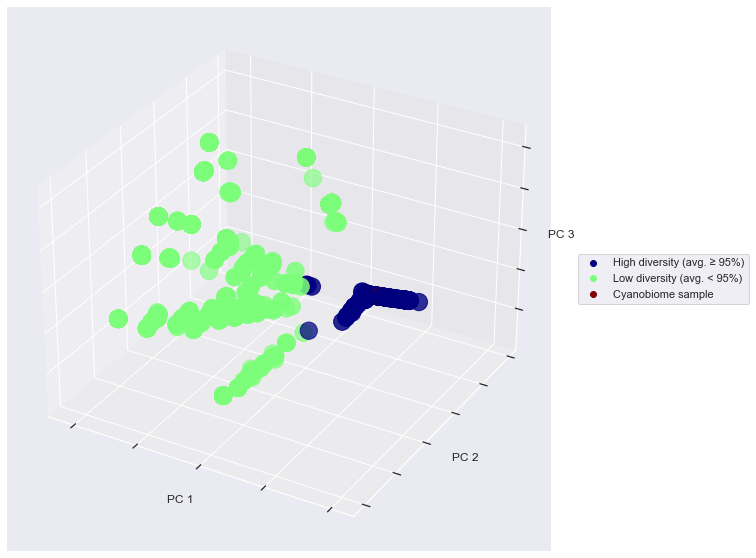

In [55]:
fig = bc_pc.plot(sample_md, 'subject', axis_labels=('PC 1', 'PC 2', 'PC 3'), cmap='jet', s=300)

fig.set_size_inches(20, 10)

In [69]:
len(sample_md[sample_md['diversity'] == 'big_producer'])

631

**Obtaining List of High Diversity Samples for Dataset S1 (sheet 3)**

In [60]:
metadata_df = pd.read_csv("./cyanobiome_metadata_df-TFL200507.tsv",sep='\t',index_col=0)

taxa_dict = dict(zip(metadata_df['GenomeID'],metadata_df['Taxa']))

taxa_dict

{'RDYK01': 'Nostocales',
 'JAAHHC01': 'Moorea',
 'CACLPT01': 'Synechococcaceae',
 'CACNMF01': 'Prochlorococcus',
 'QCFV01': 'Prochlorococcus',
 'NETF01': 'Unicellular',
 'QCIU01': 'Prochlorococcus',
 'NMQC01': 'Fischerella',
 'NMQH01': 'Fischerella',
 'CACFYM01': 'Prochlorococcus',
 'JNAM01': 'Prochlorococcus',
 'ALVI01': 'Kamptonema',
 'JAAHHH01': 'Moorea',
 'JAAHGK01': 'Okeania',
 'PXQA01': 'Cyanobacteria',
 'QCFK01': 'Prochlorococcus',
 'BDGE01': 'Nostoc',
 'QCIH01': 'Prochlorococcus',
 'DPNP01': 'Synechococcales',
 'QCIC01': 'Prochlorococcus',
 'CACKEF01': 'Synechococcaceae',
 'CVSY01': 'Prochlorococcus',
 'JNAP01': 'Prochlorococcus',
 'ALVT01': 'Fischerella',
 'CACNSV01': 'Prochlorococcus',
 'JFKV01': 'Prochlorococcus',
 'JAAHHU01': 'Moorea',
 'CACIIQ01': 'Synechococcaceae',
 'DKRT01': 'Cyanobacteria',
 'CACKMQ01': 'Prochlorococcus',
 'JFLB01': 'Prochlorococcus',
 'QCPQ01': 'Prochlorococcus',
 'MWPC01': 'Prochlorococcus',
 'JAACQX01': 'Cyanobacteria',
 'QBVT01': 'Prochlorococcus',

In [71]:
col1,col2,col3 = [],[],[]

high_sample_md = sample_md[sample_md['diversity'] == 'big_producer']

for item in high_sample_md.index:
    if item != 'MIBiG':
        bgc_count = len(glob.glob('./ncbi_antismash/nf_output/%s.fasta_output_results/*.region*.gbk'%item))
        col1.append(item)
        col2.append(taxa_dict[item])
        col3.append(bgc_count)
        frames = {"Genome ID":col1,"Taxa ID":col2,"# of BGCs":col3}
        high_bio_df = pd.DataFrame(data=frames)
    
high_bio_df

,Genome ID,Taxa ID,# of BGCs
0,AADV02,Crocosphaera,14
1,AAVU01,Lyngbya,2
2,AAVW01,Nodularia,12
3,AAXW01,Crocosphaera,16
4,ABRS01,Coleofasciculus,13
...,...,...,...
625,RSCL01,Calothrix,31
626,RSCM01,Trichormus,13
627,RSCN01,Nostoc,15
628,SIHH01,Phormidium,5


In [73]:
high_bio_df.to_csv("./outputs/high_bio_df-TFL201112.tsv",sep='\t')